In [1]:
file_path = "./MLHomework_Toxicity/train_origin.csv"
import pandas as pd
file = pd.read_csv(file_path)
df = pd.DataFrame(file)

In [2]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [3]:
from tqdm import tqdm
from collections import defaultdict
length_to_target = defaultdict(list)
length_to_num_cases = defaultdict(int)
for i in tqdm(range(df.shape[0])):
    text, target = df.loc[i]['comment_text'], df.loc[i]['target']
    length = len(tokenizer.tokenize(text))
    length_to_target[length].append(target)
    length_to_num_cases[length] += 1

100%|██████████| 1777800/1777800 [28:19<00:00, 1045.93it/s]


In [4]:
import numpy as np

In [5]:
length_to_mean = {length:np.mean(length_to_target[length]) for length in length_to_target}
length_to_std = {length:np.std(length_to_target[length]) for length in length_to_target}

In [6]:
x = list(range(300))
total_num_cases = np.sum([len(length_to_target[length]) for length in length_to_target])
num_cases = [(len(length_to_target[length]) if length in length_to_target else 0) for length in x]
mean = [(length_to_mean[length] if length in length_to_mean else 0) for length in x]
std = [(length_to_std[length] if length in length_to_std else 0) for length in x]

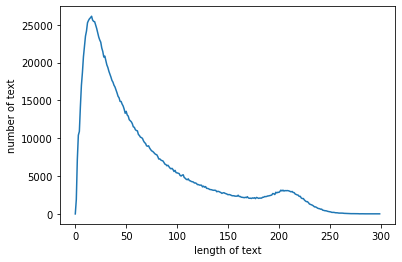

In [7]:
import matplotlib.pyplot as plt
plt.plot(x, num_cases)
plt.xlabel("length of text")
plt.ylabel("number of text")
plt.savefig("trainset-PDF.png")

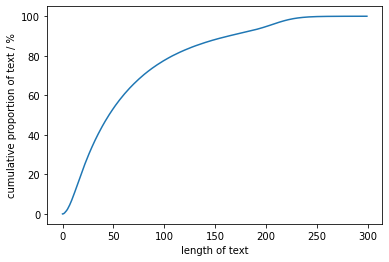

In [8]:
plt.plot(x, 100*np.cumsum(num_cases) / total_num_cases)
plt.xlabel("length of text")
plt.ylabel("cumulative proportion of text / %")
plt.savefig("trainset-CDF.png")

In [9]:
(np.cumsum(num_cases) / total_num_cases)[256], (np.cumsum(num_cases) / total_num_cases)[200]

(0.9988558893013837, 0.9477297783777703)

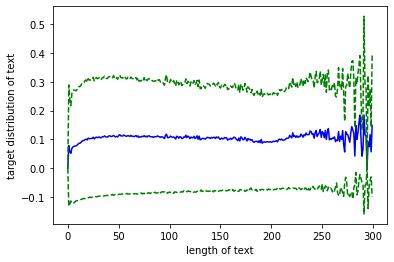

In [39]:
mean, std = np.array(mean), np.array(std)
plt.plot(x, mean, color="blue")
plt.plot(x, mean+std, color="green", linestyle='dashed')
plt.plot(x, mean-std, color="green", linestyle='dashed')
plt.xlabel("length of text")
plt.ylabel("target distribution of text")
plt.savefig("trainset-target-distribution.png")

In [1]:
from transformers import AdamW, get_cosine_schedule_with_warmup, get_constant_schedule
help(get_cosine_schedule_with_warmup)

Help on function get_cosine_schedule_with_warmup in module transformers.optimization:

get_cosine_schedule_with_warmup(optimizer: torch.optim.optimizer.Optimizer, num_warmup_steps: int, num_training_steps: int, num_cycles: float = 0.5, last_epoch: int = -1)
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.
    
    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The total number of training steps.
        num_cycles (:obj:`float`, `optional`, defaults to 0.5):
            The number of waves in the cosine schedule (the defaults is to just decrease from

In [1]:
import numpy as np
import pandas as pd
import requests
import glob
import sys
import os
from tqdm import tqdm
def submission_path_to_df(path):
    return pd.DataFrame(pd.read_csv(path, header=None, sep=" "))

def df_to_lines(df):
    return [f"{int(sample_id)} {sample_pred}" for sample_id, sample_pred in [
        df.iloc[i].values.tolist() for i in range(df.shape[0])
    ]]
def search_path(path = "../"):
    for subpath in [os.path.join(path, _) for _ in os.listdir(path)]:
        if os.path.isdir(subpath):
            for _ in search_path(subpath):
                yield _
        elif "submission.txt" in subpath and subpath[3:5]!="0.":
            yield subpath
        else:
            pass
submission_paths = [_ for _ in search_path()]
submission_paths

['../single-ft-freeze-512*1/submission.txt',
 '../submissions_from_24/single-ft-real/submission.txt',
 '../submissions_from_24/data/MLHomeworks_client/submission.txt',
 '../submissions_from_24/data/MLHomework_Toxicity/submission.txt',
 '../submissions_from_24/single-ft-freeze/submission.txt',
 '../submissions_from_24/exp/tmp-ce-3e-05/submission.txt',
 '../submissions_from_24/exp/tmp-ce-1e-06/submission.txt',
 '../submissions_from_24/exp/single-ft-freeze-100*3/submission.txt',
 '../submissions_from_24/exp/microsoft/deberta-v3-base_with_DebertaRegressionHead_mse_3e-5/submission.txt',
 '../submissions_from_24/exp/microsoft/deberta-v3-base_with_DebertaRegressionHead_ce/eval-80000submission.txt',
 '../submissions_from_24/exp/microsoft/deberta-v3-base_with_DebertaRegressionHead_ce/eval-40000submission.txt',
 '../submissions_from_24/exp/microsoft/deberta-v3-base_with_DebertaRegressionHead_ce/eval-60000submission.txt',
 '../submissions_from_24/exp/microsoft/deberta-v3-base_with_DebertaRegressi

In [2]:
len(submission_paths)

69

In [3]:
def main(ip = "115.236.52.125", port = "4000", sid = "TEAM_15", token = "tri_man_walk",
         ans = None, problem = "Toxicity_evaluate", verbose=1):
    if verbose: print("正在提交...")
    url = "http://%s:%s/jsonrpc" % (ip, port)
    
    payload = {
        "method": problem,
        "params": [ans],
        "jsonrpc": "2.0",
        "id": 0,
    }
    response = requests.post(
        url,
        json=payload,
        headers={"token": token, "sid": sid}
    ).json()
    
    import time
    time.sleep(1)
    
    if verbose: print(response)
    if "auth_error" in response:
        print("您的认证信息有误")
        return response["auth_error"]
    elif "error" not in response:
        if verbose: print("测试完成，请查看分数")
        return response["result"]
    else:
        print("提交文件存在问题，请查看error信息")
        return response["error"]["data"]["message"]

In [8]:
dfs = [submission_path_to_df(path) for path in submission_paths]
dfs_paths = []
df_string = []
for df,path in zip(dfs,submission_paths):
    if str(df) not in df_string:
        dfs_paths.append((df,path))
        df_string.append(str(df))
df_to_path = {str(df):path for df,path in dfs_paths}
len(df_to_path)

62

In [9]:
df_score = [(df,main(ans=df_to_lines(df), verbose=0)) for df,path in tqdm(dfs_paths)]
df_score = sorted(df_score, key=lambda x:x[1], reverse=True)


100%|██████████| 62/62 [03:55<00:00,  3.79s/it]


In [13]:
target_df = submission_path_to_df("../0.94254109_submission.txt")

In [14]:
a = np.array([df[1].tolist() for df,score in df_score]).T
b = np.array(target_df[1].tolist())
weights = np.linalg.solve(a[:len(df_score),:],b[:len(df_score)])
for i,(df,score) in enumerate(df_score):
    print(f"{weights[i]:.3f} * {score:.8f} - {df_to_path[str(df)]}")

0.034 * 0.93753049 - ../submissions_from_24/exp/microsoft/deberta-v3-base_with_DebertaRegressionHead_ce/eval-200000submission.txt
0.185 * 0.93605033 - ../exp/bert-large-uncased_with_TwoLayerRegressionHead_ce/eval-100000submission.txt
0.015 * 0.93596673 - ../submissions_from_24/exp/microsoft/deberta-v3-base_with_DebertaRegressionHead_ce/eval-160000submission.txt
0.656 * 0.93523128 - ../exp/BERT_with_TwoLayerRegressionHead_ce/submission.txt
0.022 * 0.93518120 - ../exp/bert-large-uncased_with_TwoLayerRegressionHead_ce/eval-90000submission.txt
0.385 * 0.93398387 - ../submissions_from_24/exp/single-ft-freeze-100*3-test/submission.txt
0.032 * 0.93386654 - ../exp/bert-large-uncased_with_TwoLayerRegressionHead_ce/submission.txt
-0.172 * 0.93280140 - ../exp/BERT_with_TwoLayerRegressionHead_mse/submission.txt
-0.053 * 0.93265944 - ../submissions_from_24/exp/single-ft-freeze-100*3/submission.txt
0.010 * 0.93253124 - ../submissions_from_24/exp/microsoft/deberta-v3-base_with_DebertaRegressionHead_c

In [15]:
main(ans=df_to_lines(target_df))

正在提交...
{'result': 0.9425410948698637, 'id': 0, 'jsonrpc': '2.0'}
测试完成，请查看分数


0.9425410948698637

Text(0, 0.5, 'y')

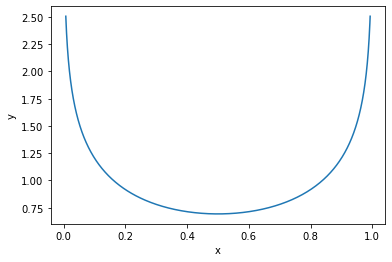

In [32]:
import matplotlib.pyplot as plt
x = np.linspace(-5,5,1000)
p = 0.5 #np.linspace(0,1,1000)
y = (p-1)*x - np.log(np.exp(-x)+1)
plt.plot(1/(np.exp(-x)+1), -y)
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'y')

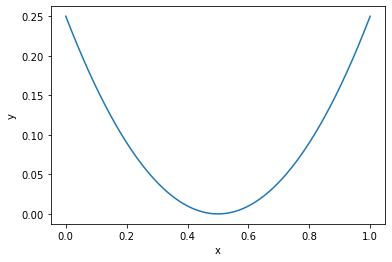

In [31]:
import matplotlib.pyplot as plt
x = np.linspace(0,1,1000)
plt.plot(x, (x-0.5)**2)
plt.xlabel("x")
plt.ylabel("y")

In [33]:
import numpy as np

In [42]:
type(np.random.permutation(1000000).tolist()[0])

int